In [1]:
import numpy as np 
import tensorflow as tf 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
#Distribution of the training data
class DataDistribution:
    def __init__(self,mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def samples(self, N):
        return np.random.normal(self.mu, self.sigma,N)

In [3]:
def plot_data_distribution():
    distribution = DataDistribution(4,0.5)
    samples = distribution.samples(1000)
    samples = pd.Series(samples)
    samples.plot(kind="density")
    plt.grid(True)
    plt.show()

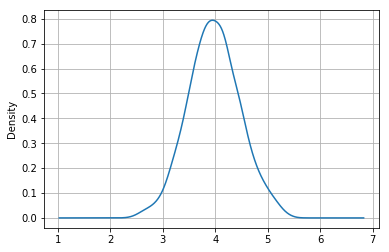

In [4]:
#Plots the density curve of the training data that the generator tries to estimate
plot_data_distribution()

In [5]:
#Noisy signal which serves as an input to the generator
class GeneratorNoiseDistribution:
    def __init__(self,limit):
        self.limit = limit
    def sample_noise(self,N):
        return np.linspace(-self.limit, self.limit,N) + np.random.random() * 0.001

In [6]:
def plot_noise_distribution():
    distribution = GeneratorNoiseDistribution(8)
    samples = distribution.sample_noise(1000)
    samples = pd.Series(samples)
    samples.plot(kind = "density")
    plt.grid(True)
    plt.show()

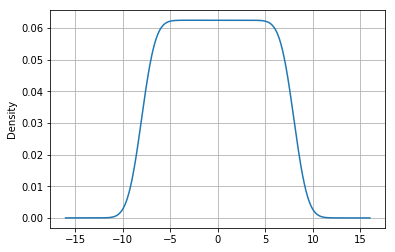

In [7]:
plot_noise_distribution()

In [8]:
class Model:
    def __init__(self):
        pass
    def new_weights(self, shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev = 1.0), name = name)
    def new_biases(self, length, name):
        return tf.Variable(tf.constant(0.0, shape = [length]), name = name)
    def linear(self, data_input,weights, biases):
        return tf.matmul(data_input, weights) + biases

In [9]:
class Generator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w2")
        b2 = self.new_biases(self.num_output_neurons,"b2")   
        layer_1 = tf.nn.softplus(self.linear(x, w1, b1))
        layer_2 = self.linear(layer_1,w2,b2)
        return layer_2              

In [10]:
class Discriminator(Model):
    def __init__(self,num_input_neurons,num_hidden_neurons,num_output_neurons):
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons
    def get_output(self,x):
        w1 = self.new_weights([self.num_input_neurons,self.num_hidden_neurons],"w1")
        b1 = self.new_biases(self.num_hidden_neurons,"b1")
        w2 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w2")
        b2 = self.new_biases(self.num_hidden_neurons,"b2")
        w3 = self.new_weights([self.num_hidden_neurons, self.num_hidden_neurons],"w3")
        b3 = self.new_biases(self.num_hidden_neurons,"b3")
        w4 = self.new_weights([self.num_hidden_neurons, self.num_output_neurons],"w4")
        b4 = self.new_biases(self.num_output_neurons,"b4")
        layer_1 = tf.nn.relu(self.linear(x, w1, b1))
        layer_2 = tf.nn.relu(self.linear(layer_1,w2,b2))
        layer_3 = tf.nn.relu(self.linear(layer_2,w3,b3))
        layer_4 = tf.sigmoid(self.linear(layer_3,w4,b4))
        return layer_4

In [11]:
def log(x):
    return tf.log(tf.maximum(x,1e-5))

In [12]:
G = Generator(1,8,1)
D = Discriminator(1,8,1)
x_d = tf.placeholder(tf.float32, [None,1])
x_g = tf.placeholder(tf.float32, [None,1])
g_output = G.get_output(x_g)
d1 = D.get_output(x_d)
d2 = D.get_output(g_output)
loss_d = tf.reduce_mean(-log(d1) - (1 - d2))
loss_g = tf.reduce_mean(-log(d2))

In [13]:
initial_learning_rate = 0.05
decay = 0.95
num_decay_steps = 1000
global_step = tf.Variable(0, trainable = True)
learning_rate = tf.train.exponential_decay(initial_learning_rate,global_step,num_decay_steps, decay, staircase = True)
train_d = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_d)
train_g = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_g)

In [14]:
def gen_data_sample(batch_size):
    return DataDistribution(0,1).samples(batch_size).reshape((-1,1))
def gen_noise_sample(batch_size):
    return GeneratorNoiseDistribution(8).sample_noise(batch_size).reshape((-1,1))

In [15]:
epoch = 1000
batch_size = 8
session = tf.Session()

In [16]:
def optimize(epoch, batch_size):
    for i in xrange(epoch):
        session.run(tf.global_variables_initializer())
        d_input = gen_data_sample(batch_size)
        z_noise = gen_noise_sample(batch_size)
       
        session.run(train_d, { x_d: d_input,
                                   x_g: z_noise})
        z_noise = gen_noise_sample(batch_size)
        session.run(train_g, {x_g: z_noise})
        loss_discriminator, loss_generator = session.run([loss_d, loss_g], {
                                                x_d: d_input,
                                                x_g: z_noise})
        print "Epoch: {},Discriminator Loss: {}, Generator Loss: {}".format(i, loss_discriminator, loss_generator)
       

In [17]:
optimize(epoch,batch_size)

Epoch: 0,Discriminator Loss: -0.103443942964, Generator Loss: 0.47323474288
Epoch: 1,Discriminator Loss: 0.826062619686, Generator Loss: 0.00231499806978
Epoch: 2,Discriminator Loss: 8.68288516998, Generator Loss: 0.318146795034
Epoch: 3,Discriminator Loss: 0.160373985767, Generator Loss: 1.49011668782e-07
Epoch: 4,Discriminator Loss: 0.100334972143, Generator Loss: 0.0581748597324
Epoch: 5,Discriminator Loss: 0.0410004928708, Generator Loss: 0.0161449573934
Epoch: 6,Discriminator Loss: 0.430436432362, Generator Loss: 0.0853071957827
Epoch: 7,Discriminator Loss: 1.32215774059, Generator Loss: 1.39480680446e-05
Epoch: 8,Discriminator Loss: 0.418759167194, Generator Loss: 0.23075646162
Epoch: 9,Discriminator Loss: 0.634169280529, Generator Loss: 3.20539808273
Epoch: 10,Discriminator Loss: 0.136435344815, Generator Loss: 0.266071349382
Epoch: 11,Discriminator Loss: -0.302047163248, Generator Loss: 0.545399069786
Epoch: 12,Discriminator Loss: -0.582368373871, Generator Loss: 1.89215731621


Epoch: 110,Discriminator Loss: -0.0428053811193, Generator Loss: 0.319925040007
Epoch: 111,Discriminator Loss: 0.364428699017, Generator Loss: 0.040341027081
Epoch: 112,Discriminator Loss: 0.0662605911493, Generator Loss: 0.0287735573947
Epoch: 113,Discriminator Loss: -0.877304792404, Generator Loss: 11.512925148
Epoch: 114,Discriminator Loss: 0.30825394392, Generator Loss: 0.318253546953
Epoch: 115,Discriminator Loss: 1.39834880829, Generator Loss: 0.0838051363826
Epoch: 116,Discriminator Loss: 0.898004710674, Generator Loss: 0.162837937474
Epoch: 117,Discriminator Loss: 0.4044893682, Generator Loss: 0.296481609344
Epoch: 118,Discriminator Loss: 0.298133194447, Generator Loss: 0.0
Epoch: 119,Discriminator Loss: -0.0331244021654, Generator Loss: 0.112875364721
Epoch: 120,Discriminator Loss: 0.339890986681, Generator Loss: 0.00255993171595
Epoch: 121,Discriminator Loss: 0.168569266796, Generator Loss: 0.00348078063689
Epoch: 122,Discriminator Loss: -0.424475193024, Generator Loss: 2.783

Epoch: 219,Discriminator Loss: 0.525106191635, Generator Loss: 0.000787662691437
Epoch: 220,Discriminator Loss: 0.346666634083, Generator Loss: 0.0634604990482
Epoch: 221,Discriminator Loss: 0.328684538603, Generator Loss: 0.109960898757
Epoch: 222,Discriminator Loss: 2.22062468529, Generator Loss: 0.281028389931
Epoch: 223,Discriminator Loss: 0.207620427012, Generator Loss: 0.0258869212121
Epoch: 224,Discriminator Loss: 0.13297329843, Generator Loss: 0.000822722795419
Epoch: 225,Discriminator Loss: -0.728822231293, Generator Loss: 5.47651386261
Epoch: 226,Discriminator Loss: 0.401591718197, Generator Loss: 0.0133243240416
Epoch: 227,Discriminator Loss: 1.90202641487, Generator Loss: 0.247815489769
Epoch: 228,Discriminator Loss: -0.151395201683, Generator Loss: 5.84392261505
Epoch: 229,Discriminator Loss: 2.86368989944, Generator Loss: 0.0680879279971
Epoch: 230,Discriminator Loss: 1.2981607914, Generator Loss: 0.0238837487996
Epoch: 231,Discriminator Loss: 0.0123840682209, Generator L

Epoch: 327,Discriminator Loss: 0.108449503779, Generator Loss: 0.0546689033508
Epoch: 328,Discriminator Loss: 1.0044580698, Generator Loss: 0.310255646706
Epoch: 329,Discriminator Loss: 0.734769105911, Generator Loss: 0.0735514685512
Epoch: 330,Discriminator Loss: 2.67952895164, Generator Loss: 0.226162865758
Epoch: 331,Discriminator Loss: -0.858565449715, Generator Loss: 7.11862754822
Epoch: 332,Discriminator Loss: 0.142666459084, Generator Loss: 6.72059968565e-06
Epoch: 333,Discriminator Loss: 0.581153094769, Generator Loss: 0.022936180234
Epoch: 334,Discriminator Loss: -0.0648639202118, Generator Loss: 0.287599682808
Epoch: 335,Discriminator Loss: -0.682207405567, Generator Loss: 1.98038101196
Epoch: 336,Discriminator Loss: -0.689247369766, Generator Loss: 5.44479179382
Epoch: 337,Discriminator Loss: 0.852597415447, Generator Loss: 0.0100520066917
Epoch: 338,Discriminator Loss: 1.27925610542, Generator Loss: 0.354826509953
Epoch: 339,Discriminator Loss: 2.35044312477, Generator Loss

Epoch: 432,Discriminator Loss: -0.174652054906, Generator Loss: 4.43835449219
Epoch: 433,Discriminator Loss: -0.183990716934, Generator Loss: 0.370343655348
Epoch: 434,Discriminator Loss: 0.741985321045, Generator Loss: 0.271081805229
Epoch: 435,Discriminator Loss: 0.0830157995224, Generator Loss: 0.00364928273484
Epoch: 436,Discriminator Loss: 0.407642543316, Generator Loss: 0.00777700403705
Epoch: 437,Discriminator Loss: 0.472333103418, Generator Loss: 0.0928152352571
Epoch: 438,Discriminator Loss: 0.0928432047367, Generator Loss: 3.57628380243e-07
Epoch: 439,Discriminator Loss: -0.643009006977, Generator Loss: 9.42436981201
Epoch: 440,Discriminator Loss: -0.136717841029, Generator Loss: 0.616515278816
Epoch: 441,Discriminator Loss: -0.602838993073, Generator Loss: 11.512925148
Epoch: 442,Discriminator Loss: -0.234539836645, Generator Loss: 0.553027391434
Epoch: 443,Discriminator Loss: 1.04933977127, Generator Loss: 1.49011611938e-08
Epoch: 444,Discriminator Loss: 0.343920707703, Gen

Epoch: 537,Discriminator Loss: -0.387900829315, Generator Loss: 8.15682506561
Epoch: 538,Discriminator Loss: 0.177709117532, Generator Loss: 0.130128622055
Epoch: 539,Discriminator Loss: 0.352073192596, Generator Loss: 0.0563066937029
Epoch: 540,Discriminator Loss: -0.41950315237, Generator Loss: 9.17831420898
Epoch: 541,Discriminator Loss: 1.83743333817, Generator Loss: 0.159379929304
Epoch: 542,Discriminator Loss: 1.42624902725, Generator Loss: 0.260356158018
Epoch: 543,Discriminator Loss: 0.196172043681, Generator Loss: 0.000590452109464
Epoch: 544,Discriminator Loss: -0.331209242344, Generator Loss: 5.62537908554
Epoch: 545,Discriminator Loss: -0.014595001936, Generator Loss: 0.053760021925
Epoch: 546,Discriminator Loss: 0.050797984004, Generator Loss: 0.0152999637648
Epoch: 547,Discriminator Loss: 0.0205229241401, Generator Loss: 9.17944453249e-06
Epoch: 548,Discriminator Loss: 0.317145913839, Generator Loss: 4.77872467041
Epoch: 549,Discriminator Loss: 0.850216984749, Generator L

Epoch: 643,Discriminator Loss: 0.645623683929, Generator Loss: 0.000706044316757
Epoch: 644,Discriminator Loss: -0.634537816048, Generator Loss: 10.6429843903
Epoch: 645,Discriminator Loss: 0.222692489624, Generator Loss: 4.49920749664
Epoch: 646,Discriminator Loss: -0.0309068076313, Generator Loss: 0.115512177348
Epoch: 647,Discriminator Loss: -0.571150898933, Generator Loss: 9.01086997986
Epoch: 648,Discriminator Loss: 2.14055109024, Generator Loss: 0.154600173235
Epoch: 649,Discriminator Loss: 1.01870250702, Generator Loss: 0.0298261940479
Epoch: 650,Discriminator Loss: 0.257453471422, Generator Loss: 0.273761689663
Epoch: 651,Discriminator Loss: 0.0912015289068, Generator Loss: 0.206358522177
Epoch: 652,Discriminator Loss: 3.5222029686, Generator Loss: 0.101987197995
Epoch: 653,Discriminator Loss: 0.0125540606678, Generator Loss: 0.0869450867176
Epoch: 654,Discriminator Loss: -0.374042868614, Generator Loss: 4.41628313065
Epoch: 655,Discriminator Loss: 0.411211103201, Generator Los

Epoch: 751,Discriminator Loss: -0.668432414532, Generator Loss: 5.20353794098
Epoch: 752,Discriminator Loss: 0.062703281641, Generator Loss: 0.00872201658785
Epoch: 753,Discriminator Loss: 1.37400341034, Generator Loss: 0.430761426687
Epoch: 754,Discriminator Loss: 0.309286266565, Generator Loss: 0.0263230316341
Epoch: 755,Discriminator Loss: 0.735411524773, Generator Loss: 0.000458029971924
Epoch: 756,Discriminator Loss: 0.328130453825, Generator Loss: 5.31982232133e-06
Epoch: 757,Discriminator Loss: -0.371413946152, Generator Loss: 4.27179145813
Epoch: 758,Discriminator Loss: 0.378003746271, Generator Loss: 0.000500327441841
Epoch: 759,Discriminator Loss: 0.089689552784, Generator Loss: 0.0417612791061
Epoch: 760,Discriminator Loss: 0.299541205168, Generator Loss: 0.0789649561048
Epoch: 761,Discriminator Loss: 1.04476070404, Generator Loss: 0.316963851452
Epoch: 762,Discriminator Loss: 0.650246441364, Generator Loss: 0.0210849512368
Epoch: 763,Discriminator Loss: 0.815696299076, Gene

Epoch: 858,Discriminator Loss: 0.0800305232406, Generator Loss: 0.163774251938
Epoch: 859,Discriminator Loss: 0.649021744728, Generator Loss: 0.573048233986
Epoch: 860,Discriminator Loss: 0.108807049692, Generator Loss: 0.221668332815
Epoch: 861,Discriminator Loss: -0.530497014523, Generator Loss: 6.21257305145
Epoch: 862,Discriminator Loss: -0.810575485229, Generator Loss: 6.66986465454
Epoch: 863,Discriminator Loss: -0.828205704689, Generator Loss: 7.69912719727
Epoch: 864,Discriminator Loss: 0.147654294968, Generator Loss: 0.343994110823
Epoch: 865,Discriminator Loss: 0.324064135551, Generator Loss: 0.00038850918645
Epoch: 866,Discriminator Loss: -0.382114708424, Generator Loss: 1.13246428967
Epoch: 867,Discriminator Loss: -0.443725407124, Generator Loss: 5.37438678741
Epoch: 868,Discriminator Loss: 0.414129853249, Generator Loss: 0.0213371980935
Epoch: 869,Discriminator Loss: 0.923392772675, Generator Loss: 0.474047899246
Epoch: 870,Discriminator Loss: 0.505004525185, Generator Los

Epoch: 963,Discriminator Loss: -0.240363270044, Generator Loss: 0.686682641506
Epoch: 964,Discriminator Loss: 3.83853507042, Generator Loss: 1.00894629955
Epoch: 965,Discriminator Loss: -0.760938644409, Generator Loss: 7.43253040314
Epoch: 966,Discriminator Loss: 0.235027879477, Generator Loss: 0.0
Epoch: 967,Discriminator Loss: -0.271387934685, Generator Loss: 2.91525506973
Epoch: 968,Discriminator Loss: 0.0567469187081, Generator Loss: 0.00849473662674
Epoch: 969,Discriminator Loss: -0.913118243217, Generator Loss: 6.49866962433
Epoch: 970,Discriminator Loss: -0.297259271145, Generator Loss: 2.56818890572
Epoch: 971,Discriminator Loss: 0.352289110422, Generator Loss: 5.29925727844
Epoch: 972,Discriminator Loss: -0.495901286602, Generator Loss: 0.832511007786
Epoch: 973,Discriminator Loss: 2.13132953644, Generator Loss: 0.00499351834878
Epoch: 974,Discriminator Loss: 0.675129413605, Generator Loss: 0.100551962852
Epoch: 975,Discriminator Loss: -0.90173047781, Generator Loss: 8.5747032

In [19]:
def plot_result():
    real_data = pd.Series(gen_data_sample(1000).ravel())
    generated_data = pd.Series( session.run(g_output,{x_g: gen_noise_sample(1000)}).ravel())
    real_data.plot(kind = "density", label = "real data")
    generated_data.plot(kind = "density", label = "generated data")
    noise = pd.Series(gen_noise_sample(1000).ravel())
    noise.plot(kind = "density", label = "input noise")
    plt.legend(loc = "upper right")
    plt.show()

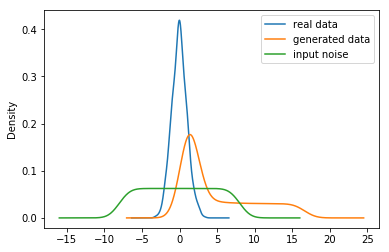

In [20]:
plot_result()

In [20]:
session.close()